#Basic model 

**By Nicolas Fidel ING1**

The purpose of this notebook is to create and train a first model that will allow to identify the speaker

For this we will have several steps:
- Create a dataset 
- Separate the dataset into training and verification data
- Train the model
- Verify the accuracy of the model
- Make predictions on the data

**Scheme of an AI process on audio files**

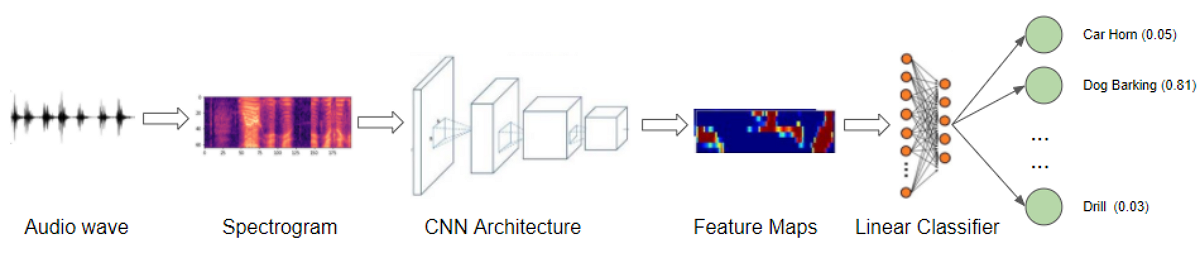

Sources : https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

# What is the problem? 

We are looking to create an AI that will recognize who the speaker is in an audio clip.

# What do we want to predict? 

We want to predict who is speaking in an audio file among N speakers.

We can see that we are dealing with a multiclass classification problem, in our case the class number is the number of speakers. Each class (speaker) is associated with a certain number of audio files which is not the same for all. 


In artificial intelligence the most important thing is to understand the problem and what we are trying to do.

# Import librairies
As the preproccesing notebook says we will use Pytorch to do this let's import torch and torchaudio

Librairies:
- tqdm: Display loading bar on iteration on array
- pandas: To manipulate dataframe
- numpy: Because numpy is always needed
- pytorch: create and manipulate neural network
- torchaudio: signal proccessing
- matplotlib: plot magnific graph

In [1]:
import torch
import torchaudio
import pandas as pd
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
from torch import nn


print(torch.__version__)
print(torchaudio.__version__)

1.10.0+cu111
0.10.0+cu111


# Gpu checking

Let's check if the notebook has a gpu

In this notebook the use of a GPU is very important as it will allow the model to be trained faster.

A GPU speeds up the operations on the tensors

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan  9 20:49:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Check if GPU is available on notebook

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device

'cuda'

# Import and load the raw data

In this section we will retrieve the raw data and load it into a dataframe. This part is best described in the notebook which talks about preproccessing

## Mount drive in the notebook

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extract raw data

In [5]:
!tar xvf /content/drive/MyDrive/ESLR/train-dataset.tar.gz 
!tar xvf /content/drive/MyDrive/ESLR/test-dataset.tar.gz 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
test-dataset-comp/._387.flac
test-dataset-comp/387.flac
test-dataset-comp/._368.flac
test-dataset-comp/368.flac
test-dataset-comp/._2988.flac
test-dataset-comp/2988.flac
test-dataset-comp/._3360.flac
test-dataset-comp/3360.flac
test-dataset-comp/._692.flac
test-dataset-comp/692.flac
test-dataset-comp/._738.flac
test-dataset-comp/738.flac
test-dataset-comp/._2822.flac
test-dataset-comp/2822.flac
test-dataset-comp/._3730.flac
test-dataset-comp/3730.flac
test-dataset-comp/._2571.flac
test-dataset-comp/2571.flac
test-dataset-comp/._2121.flac
test-dataset-comp/2121.flac
test-dataset-comp/._1920.flac
test-dataset-comp/1920.flac
test-dataset-comp/._915.flac
test-dataset-comp/915.flac
test-dataset-comp/._1023.flac
test-dataset-comp/1023.flac
test-dataset-comp/._1473.flac
test-dataset-comp/1473.flac
test-dataset-comp/._1189.flac
test-dataset-comp/1189.flac
test-dataset-comp/._446.flac
test-dataset-comp/446.flac
test-d

## Load the data in a dictionnary

We are now going to create a function that will allow us to create a dictionary that associates a sound file with its speaker

In [6]:
from os import listdir
from os.path import isfile, join

In [7]:
def create_train_data(path):
    train_folder = [f for f in listdir(path)]
    train_data = list()
    for folders_name in train_folder:
        files = [f for f in listdir(path + folders_name)]
        for file in files:
            temp = {
                "file": file,
                "speaker": folders_name
            }
            if (file.endswith('.flac')):
                train_data.append(temp)
    return train_data

In [8]:
PATH_TRAIN_DATA = "/content/train-dataset/"
train_data = create_train_data(PATH_TRAIN_DATA)
train_data[:10]

[{'file': '8975-270782-0113.flac', 'speaker': '125'},
 {'file': '8975-270782-0042.flac', 'speaker': '125'},
 {'file': '8975-270782-0075.flac', 'speaker': '125'},
 {'file': '8975-270782-0039.flac', 'speaker': '125'},
 {'file': '8975-270782-0098.flac', 'speaker': '125'},
 {'file': '8975-270782-0055.flac', 'speaker': '125'},
 {'file': '8975-270782-0101.flac', 'speaker': '125'},
 {'file': '8975-270782-0084.flac', 'speaker': '125'},
 {'file': '8975-270782-0005.flac', 'speaker': '125'},
 {'file': '8975-270782-0083.flac', 'speaker': '125'}]

# Import data on a pandas Data

In [9]:
import pandas as pd 

train_data_df = pd.DataFrame.from_dict(train_data)
train_data_df

,file,speaker
0,8975-270782-0113.flac,125
1,8975-270782-0042.flac,125
2,8975-270782-0075.flac,125
3,8975-270782-0039.flac,125
4,8975-270782-0098.flac,125
...,...,...
24500,4680-16026-0012.flac,199
24501,4680-16026-0007.flac,199
24502,4680-16026-0039.flac,199
24503,4680-16041-0031.flac,199


# Load the data on Pytorch Dataset

The aim of this part is to create a Pytorch Dataset where we can process the data. This part is explained in more depth in the preproccessing notebook

In [42]:
# Dataset classe
class SpeakerDataset(Dataset):
    
    def __init__(self, audio_path_dir: str, dataframe, transformation, 
                    target_sample_rate, num_samples, device, training):
        self.audio_path_dir = audio_path_dir
        self.data = dataframe
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.training = training
    
    # len(example_list) 
    def __len__(self):
        return len(self.data)
    
    # example_list[index]
    def __getitem__(self, index):
        audio_sample_path = self.get_audio_sample_path(index)
        label = self.get_audio_sample_label(index)
        
        signal, sr = torchaudio.load(audio_sample_path)
        
        # Calculate with gpu
        signal = signal.to(self.device)
        
        # Preprocessing the signal before transformation

        signal = self.right_pad_if_necessary(signal)
        
        # Apply a function of transformation
        signal = self.transformation(signal)

        if (self.training == False):
            return signal, label, self.get_audio_sample_path(index)
        
        return signal, label
    
    # Function to pad the signal
    def right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if (length_signal < self.num_samples):
            num_differencies = self.num_samples - length_signal
            last_dimension_padding = (0, num_differencies)
            signal = torch.nn.functional.pad(signal, last_dimension_padding)
            
        return signal
    
    # Private function to get the path of a file
    def get_audio_sample_path(self, index):
        if (self.training):
          path = self.audio_path_dir + "/" + self.data.iloc[index, 1] + "/" + self.data.iloc[index, 0] 
        else:
          path = self.audio_path_dir + "/"  + self.data.iloc[index, 0] 
        return path
    
    # Private function to get the label of the audio
    def get_audio_sample_label(self, index):
        return np.int64(self.data.iloc[index, 1])

# What will be our approach? 

## Supervised or unsupervised learning? 

Machine Learning is a set of techniques that give machines the ability to learn.

There are two main types of learning in Machine Learning.
- Supervised learning 
- Unsupervised.  

In supervised learning, the algorithm is guided with prior knowledge of what the output values of the model should be. 

As a result, the model adjusts its parameters in order to reduce the difference between the results obtained and the expected results. The aim is therefore to decrease the error rate in order to increase the accuracy of the prediction 

On the other hand, unsupervised learning does not use labelled data. It is therefore impossible for the algorithm to calculate a success score with certainty. 
Its objective is therefore to deduce the clusters present in our data. 



**Scheme explain the difference between supervised vs unsurpervised learning**

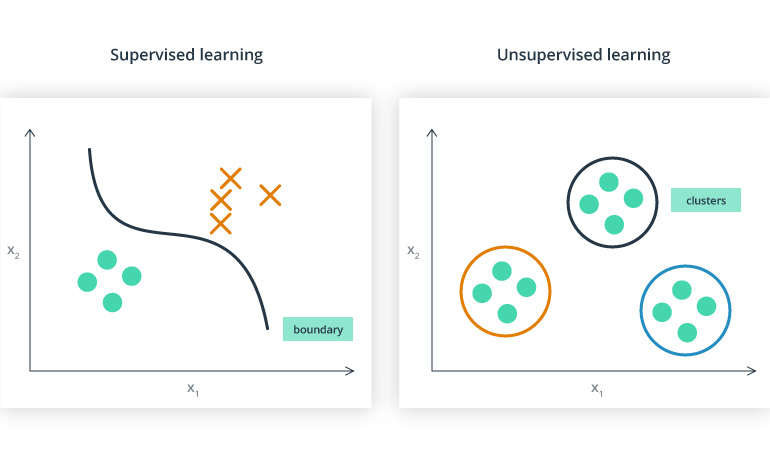


In our case we will use a supervised learning approach because our data is labelled.

## Different types of techniques: 

In order to solve a classification problem there are different possible approaches:
- Machine learning techniques (SVM, Naives Bayes) 
- Deep learning

Machine learning techniques are best used when there is not too much data or it is less dense. 

The Deep learning approach is the one we will choose because we have a lot of data and these data are quite dense. 

**Scheme which explains the difference between the two approaches**

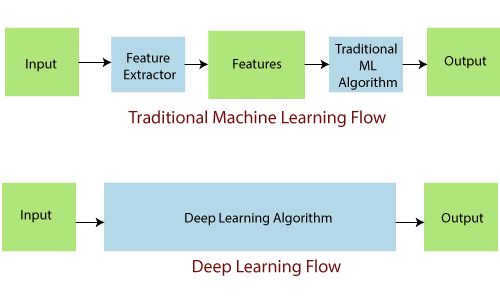

Source : https://www.tutorialandexample.com/deep-learning-tutorial/

# What is a deep learning approach? 


Deep learning is one of the main technologies of machine learning. 
Deep learning works through artificial neural networks.  The networks are composed of dozens or even hundreds of "layers" of neurons, each receiving and interpreting information from the previous layer.

## What is a Neuronal Network ?

### What is a neuron? 

Physical neurons are interconnected nerve cells, and enable the processing and transmission of chemical and electrical signals.

Artificial neurons seek to mimic the function of neurons in the brain. It is a mathematical function based on a model of biological neurons. Each neuron receives data, weighs it, calculates its sum and produces a result through a non-linear function.



**Scheme comparing a physical neuron with a virtual neuron ** 

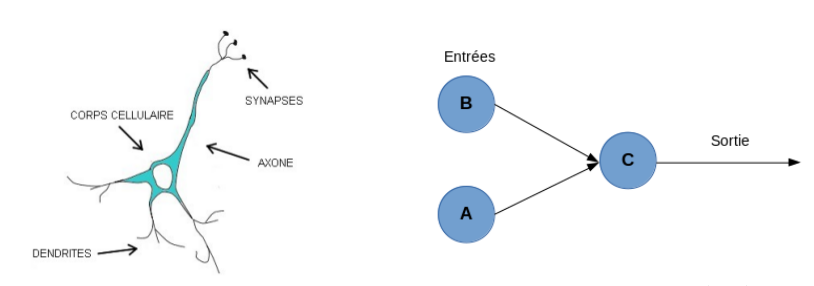

Source : https://images.squarespace-cdn.com/content/v1/519a7bc0e4b08ccdf8f31445/1523265977965-C2A4TRETIKF4TVYEPMK6/neurone.png

### What is a perceptron ?

A Perceptron is an artificial neuron. It performs calculations to detect features or patterns in the input data.

The Perceptron receives multiple input signals. If the sum of the signals exceeds a certain threshold, a signal is produced or no result is produced.

The Perceptron is a mathematical function. The input data (x) is multiplied by the weight coefficients (w). The result is a value.

**Scheme of a perceptron formula**

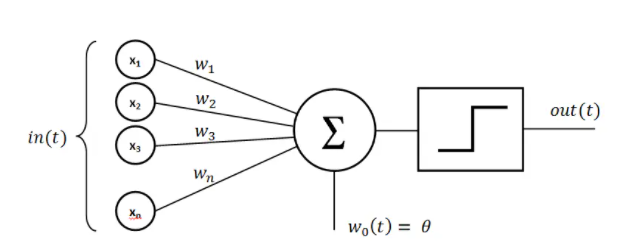

Sources : https://datascientest.com/wp-content/uploads/2021/03/perceptron-formule.png.webp

A neural network is a set of interconnected formal neurons (perceptron) allowing the solution of complex problems such as pattern recognition or natural language processing, thanks to the adjustment of weighting coefficients in a learning phase.

A neural network can take different forms depending on the object of the data it processes and on its complexity and the method of processing the data.

Network architectures have their strengths and weaknesses and can be combined to optimise results. The choice of architecture is therefore crucial and is determined mainly by the objective.

**Scheme of a basic neural network**

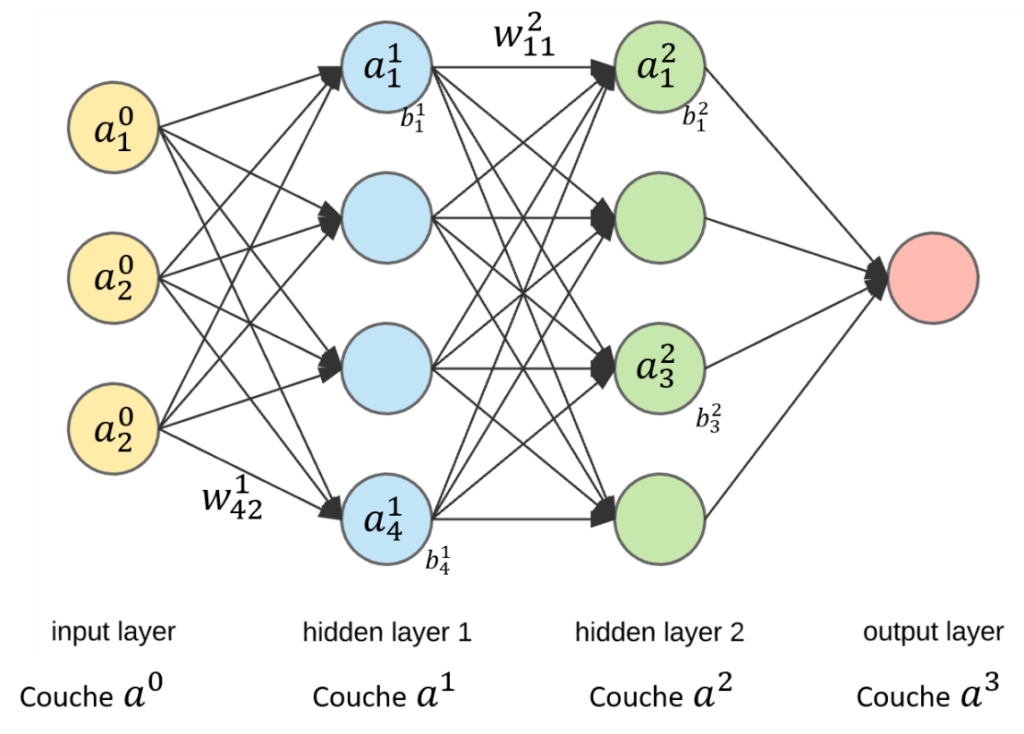

## Activate Function

In the field of artificial neural networks, the activation function is a mathematical function applied to an output signal of an artificial neuron. It is often a non-linear function that will lead to a response from the neuron.

The most used activation function: 
- ReLU
- Linear
- Gaussian

**Example of the ReLU function** 

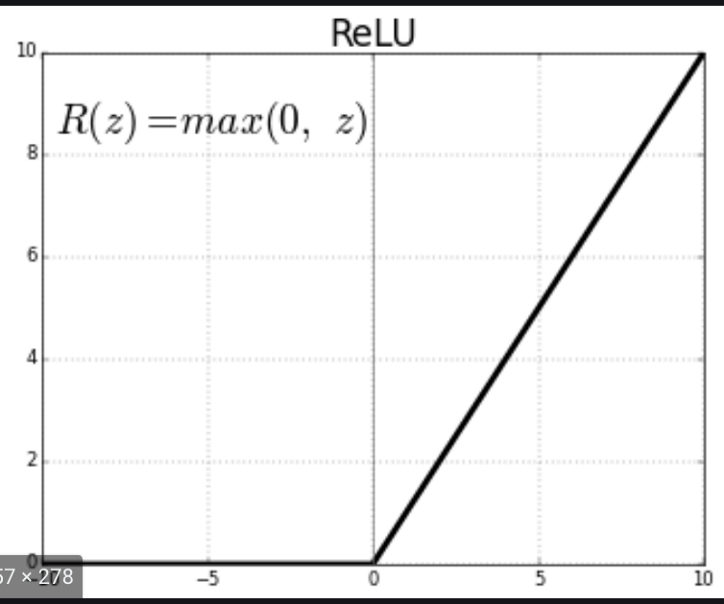

Sources : https://ichi.pro/assets/images/max/724/1*3JUMOqugWKB2SDra6x6v0A.png

# Let's create our first neural network

To define a neural network using pytorch we need to create a class that inherits from the nn.Module class

Link to the nn.Module documentation : 
https://pytorch.org/docs/stable/generated/torch.nn.Module.html

## What is Convolution Neurons  Network? 

### What is convolution : 

Convolution is an operation on two functions (f and g) that produces a third function (f*g) that expresses how the shape of one is modified by the other.

Definition a convolution between two functions f and g
\begin{align}
(f * g)(t) := \int_{-\infty}^\infty f(\tau) g(t - \tau) \, d\tau.
\end{align}

Convolution is a filtering operation

### CNN :
- Convolution layer: The role of this layer is to analyse the input signal and detect the presence of a set of features. The output of this layer is a set of feature maps 


**Scheme of a CNN**

> Bloc en retrait



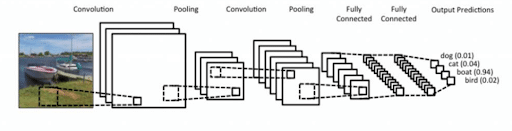

Sources : https://datascientest.com/wp-content/uploads/2020/06/CNN-8.png

## Our audio classifier :

In [11]:
class AudioClassifier (nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Fith Convolution Block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU()
        self.bn5= nn.BatchNorm2d(128)
        init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.bn5]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(in_features=128, out_features=256)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    def forward(self, x):

        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.linear(x)

        # Final output
        return x

Now let's create our neural network

The to function of pytorch allows us to say on which device we will perform the calculations.

In [12]:
model = AudioClassifier().to(device)

# Split the dataset in training, and validation set

In [13]:
SAMPLING_RATE = 16000
NUM_SAMPLE = 392400
n_fft = 2804
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate = SAMPLING_RATE,
        n_fft = 1024,
        hop_length = 512,
        n_mels = 64
) 


In [14]:
speaker_dataset = SpeakerDataset(PATH_TRAIN_DATA, train_data_df, mel_spectrogram, SAMPLING_RATE,
                                NUM_SAMPLE, device, True)
speaker_dataset

To have an optimal training we will separate our dataset in two parts: 
- A training set to train our network 
- A validation set to calculate the accuracy on data that was not used during the training 

In our case we will take 80% of the data for training and 20% for evaluation

Let's start by calculating the number of signals in both sets.


In [15]:
lengths = [int(len(speaker_dataset)*0.8), int(len(speaker_dataset)*0.2)]
lengths

[19604, 4901]

Now let's use the random_split function which will split our dataset into two subsets by mixing the order of the elements

In [16]:
training_sets, validation_sets = torch.utils.data.random_split(speaker_dataset, lengths)

Let's look at the size of the training set

In [17]:
len(training_sets)

19604

Let's look at the size of the validation set

In [18]:
len(validation_sets)

4901

We can now move on to training the model with the training set.

# Train the model : 

In this part we will train our network with our training data 

The general purpose of training is to show data to our model, it makes a prediction and then tells it if it has found the right answer or not. After that it changes the weights of the network to improve its next predictions

## How do you train a model? 

The principle of learning is to pass the input data to the neural network and then to check if the prediction is correct or not. Based on this, the weights of the network are updated (backpropagation). The aim is to continuously reduce the error rate by updating the weights of the neural network. 

It is also important to make sure that the model does not overtrain, otherwise it will have difficulty generalizing to data that it does not know.



**Diagram summarising the training process**

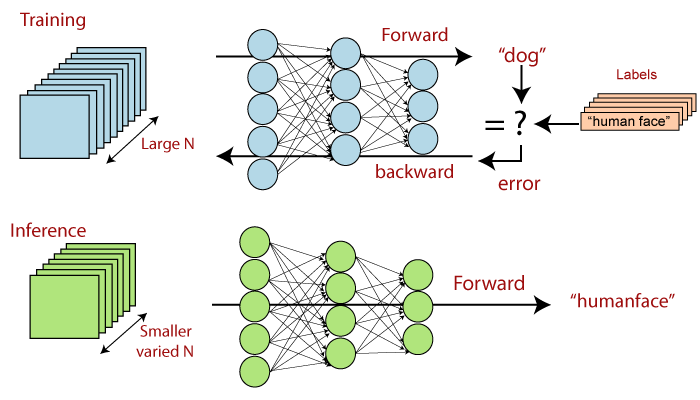

Sources : https://www.tutorialandexample.com/deep-learning-tutorial/

The batch size is a hyperparameter that defines the number of samples to be processed before updating the model parameters.

Now let's define the batch size

In [19]:
BATCH_SIZE = 64

## Dataloader

Let's start by transforming our dataset that contains all our data into a dataloader.  A datalaoder is a memory representation of a dataset.

Define a function who transform dataset to datalaoder 

In [20]:
def create_data_loader(dataset, batch_size):
    new_dataloader = DataLoader(dataset, 
                                    batch_size=batch_size)
    return new_dataloader

Transform training set to datalaoder

In [21]:
training_dataloader = create_data_loader(training_sets, BATCH_SIZE)
training_dataloader

Transform validation set to datalaoder

In [22]:
validation_dataloader = create_data_loader(validation_sets, BATCH_SIZE)
validation_dataloader

## Traning function

Let's define a learning function that will allow the model to be trained over a number n of epochs.

In this function we will define an optimizer and an error function and then we will iterate a number of epochs on our dataset to train the resets.

In [23]:
def train(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  loss_func = nn.CrossEntropyLoss()

  # Define a optimizer
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.001,
                                                  steps_per_epoch = int(len(train_dl)),
                                                  epochs=num_epochs,
                                                  anneal_strategy='linear')

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    # Print a loading bar with tqdm
    for i, data in (enumerate(tqdm(train_dl))):

        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Set the gradient to 0 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    accurary = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {accurary:.2f}')

  print('Finished Training')

We have defined our training function and can run the training on a few epochs

In [24]:
num_epochs = 8  
train(model, training_dataloader , num_epochs)

100%|██████████| 307/307 [02:22<00:00,  2.16it/s]


Epoch: 0, Loss: 5.34, Accuracy: 0.02


100%|██████████| 307/307 [02:14<00:00,  2.29it/s]


Epoch: 1, Loss: 3.95, Accuracy: 0.21


100%|██████████| 307/307 [01:50<00:00,  2.77it/s]


Epoch: 2, Loss: 2.05, Accuracy: 0.64


100%|██████████| 307/307 [01:51<00:00,  2.76it/s]


Epoch: 3, Loss: 1.03, Accuracy: 0.84


100%|██████████| 307/307 [01:51<00:00,  2.76it/s]


Epoch: 4, Loss: 0.66, Accuracy: 0.91


100%|██████████| 307/307 [01:49<00:00,  2.79it/s]


Epoch: 5, Loss: 0.50, Accuracy: 0.93


100%|██████████| 307/307 [01:50<00:00,  2.78it/s]


Epoch: 6, Loss: 0.42, Accuracy: 0.95


100%|██████████| 307/307 [01:50<00:00,  2.78it/s]

Epoch: 7, Loss: 0.37, Accuracy: 0.96
Finished Training


Now that our training is complete we can see that on the test data the model has an accuracy of 94%.

We can now try to evaluate the model on data that it never saw during the training

Let's save the state of our model in a file for that we can use a function of pytorch

In [25]:
torch.save(model.state_dict(), 'my_super_model.pth')

In [26]:
!ls | grep model

my_super_model.pth


Documentation of this function : https://pytorch.org/tutorials/beginner/saving_loading_models.html

A good article about loss function and problem of learning: https://machinelearningmastery.com/a-gentle-introduction-to-the-challenge-of-training-deep-learning-neural-network-models/

# Evaluate the model



Now that our network is trained, let's define a method to calculate its accuracy on data it has never see

In [27]:
def test_network (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates  not to change the training 
  with torch.no_grad():
    for data in tqdm(val_dl):
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)
      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)

      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')



Now let's run the accuracy calculation

In [28]:
test_network(model, validation_dataloader)

100%|██████████| 77/77 [00:33<00:00,  2.32it/s]

Accuracy: 0.94, Total items: 4901


You can see that my model has an accuracy of 92% on the data it has never seen

# Prediction for kaggle competition : 

## Load the test dataset

In [29]:
PATH_TO_TEST_DATASET = "/content/test-dataset-comp/"

import glob

files_tests = glob.glob(PATH_TO_TEST_DATASET+'*.flac')
files_tests[:10]

['/content/test-dataset-comp/3765.flac',
 '/content/test-dataset-comp/2267.flac',
 '/content/test-dataset-comp/3449.flac',
 '/content/test-dataset-comp/1969.flac',
 '/content/test-dataset-comp/3900.flac',
 '/content/test-dataset-comp/225.flac',
 '/content/test-dataset-comp/2477.flac',
 '/content/test-dataset-comp/76.flac',
 '/content/test-dataset-comp/1654.flac',
 '/content/test-dataset-comp/2309.flac']

Let's start by getting a list of all the test files 

In [30]:
tests_files = list()
for file in files_tests:
  temp = file.split('/')
  tests_files.append(temp[-1])
tests_files[:5]


['3765.flac', '2267.flac', '3449.flac', '1969.flac', '3900.flac']


Let's create a dictionary that will contain all the files that put us all at speaker 0 because we don't need them to make predictions
Let's create a dictionary that will contain all the files that put us all at speaker 0 because we don't need them to make predictions


In [31]:
result = list()
for file in tests_files:
  t = {
        "file": file,
        "speaker": '0'
  }
  result.append(t)

result[:10]

[{'file': '3765.flac', 'speaker': '0'},
 {'file': '2267.flac', 'speaker': '0'},
 {'file': '3449.flac', 'speaker': '0'},
 {'file': '1969.flac', 'speaker': '0'},
 {'file': '3900.flac', 'speaker': '0'},
 {'file': '225.flac', 'speaker': '0'},
 {'file': '2477.flac', 'speaker': '0'},
 {'file': '76.flac', 'speaker': '0'},
 {'file': '1654.flac', 'speaker': '0'},
 {'file': '2309.flac', 'speaker': '0'}]

In [32]:
tests_dataframe = pd.DataFrame(result)


### Create a dataset

Let's create the test dataset to be able to preprocess our files as in the training phase

In [44]:
test_dataset = SpeakerDataset(PATH_TO_TEST_DATASET[:-1],
                            tests_dataframe,
                            mel_spectrogram,
                            SAMPLING_RATE,
                            NUM_SAMPLE,
                            device, False)

### Make predictions to Kaggle Competition

In [43]:
def predict(model, signal):
  model.eval()
  with torch.no_grad():
    outputs = model(signal)
    _, prediction = torch.max(outputs.data ,1)
    return prediction.sum().item()

In [58]:
def create_dict_with_kaggle_predictions(dataset, model):
  predictions = list()
  for sig, sr, file_path in tqdm(dataset):
      file_path = file_path.split('/')[-1]
      file_path = file_path.split('.')[0]
      sig.unsqueeze_(0)
      temp = {
          'Id': file_path,
          'Category': predict(model, sig)
      }
      predictions.append(temp)
  return predictions

Let's run the function that will create our predictions on the test data.

In [60]:
kaggle_predictions = create_dict_with_kaggle_predictions(test_dataset, model)
kaggle_predictions[:10]

100%|██████████| 4034/4034 [00:28<00:00, 139.93it/s]


[{'Category': 99, 'Id': '3765'},
 {'Category': 68, 'Id': '2267'},
 {'Category': 154, 'Id': '3449'},
 {'Category': 214, 'Id': '1969'},
 {'Category': 4, 'Id': '3900'},
 {'Category': 68, 'Id': '225'},
 {'Category': 183, 'Id': '2477'},
 {'Category': 193, 'Id': '76'},
 {'Category': 99, 'Id': '1654'},
 {'Category': 16, 'Id': '2309'}]

Now let's turn our dictionary into a dataframe so that we can easily export it to CSV which is the submission format requested by Kaggle

In [55]:
kaggle_predictions_dataframe  = pd.DataFrame.from_dict(kaggle_predictions)
kaggle_predictions_dataframe

,Id,Category
0,3765,99
1,2267,68
2,3449,154
3,1969,214
4,3900,4
...,...,...
4029,1560,154
4030,2705,183
4031,2308,16
4032,3459,91


Let's export the model in CSV with the separator , between the different columns as requested by Kaggle

In [61]:
kaggle_predictions_dataframe.to_csv("submission.csv", index=False, sep=',', encoding='utf-8')

In [63]:
!ls | grep submission

submission.csv


### Problem with my prediction on Kaggle competition :

I am disappointed because even if I managed to train a model that on the validation data obtains an accuracy of 94% I can not submit to have a good score on kaggle I do not understand my problem. I suspect it is my prediction function but I can't find the error. I see this as a small defeat.

**Screenshot of Kaggle learderboard**


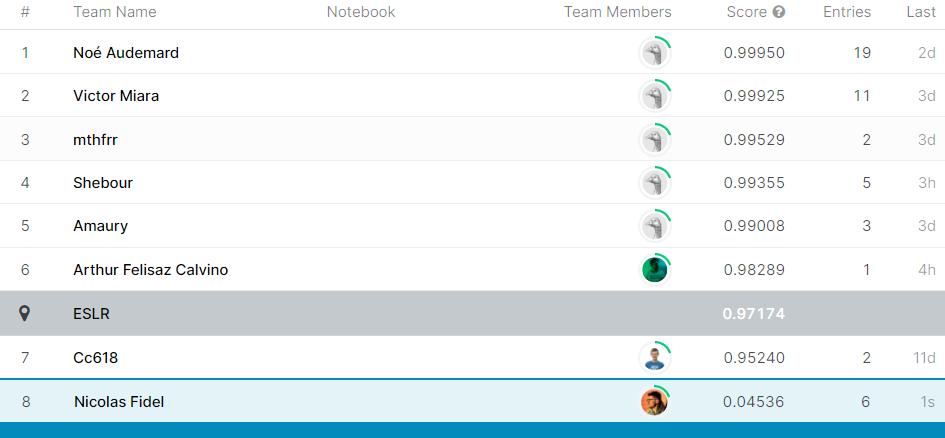

Source : https://www.kaggle.com/c/speaker-identification/leaderboard

# Conclusion 

To conclude, making this notebook took me a lot of time and I learned a lot. 

Having never used pytorch I learned all its concepts and I really appreciated this Framework coming from TensorFlow, we see that things are thought differently. 

This project allowed me to revise and deepen my notions in machine learning, I could take the time to watch videos and read articles to really understand some concepts.

Moreover, I had never done classification on signals, so I was able to learn how to do preprocessing on signals and their characteristics. 

At the beginning of the project I had trouble configuring CUDA on my PC, I had a lot of performance problems which made me think and look for information on how to optimize a model, I also learned how to profile python code to try to understand what made my calculation slow.

Even if my results are not the best and I didn't manage to do everything I wanted to do I am proud of myself and the work I was able to accomplish. I'm disappointed that I managed to train model locally but failed to export my values for the Kaggle ranking.

I want to say that the project was hard but very interesting and I really enjoyed working on it during the holidays, I'm still as motivated as ever to join the ESLR and ready to work a lot on artificial intelligence projects.  


# Sources:

## Explain about classification: 
https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212

## Article explain deep learning:
https://datascientest.com/deep-learning-definition